In [1]:
import jax.numpy as jnp
from jax import jit, grad, lax, random, vmap
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import jax
import cvxpy as cp
from jax import debug
import hj_reachability as hj
from jax.scipy.interpolate import RegularGridInterpolator
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import os

# Dynamics

Fixed Tether

The fixed tether dynamics are obtained by taking the equilibrium of forces in the tangential direction:
\begin{align*}
x &= l \sin{\theta(t)} \\
\dot{x} &= l \cos{\theta(t)} \dot{\theta(t)}
\end{align*}

\begin{align*}
\Sigma F_{\text{tangential}} &= T - mg \sin{\theta} + C_D (V_{\text{wind}} - \dot{x})  = T - mg \sin{\theta} + C_D (V_{\text{wind}}- l \cos{\theta}\dot{\theta}) = ml \ddot{\theta}\\
\implies \ddot{\theta} &= \frac{T}{ml} - \frac{g}{l}\sin{\theta} +\frac{C_D}{ml}(V_{\text{wind}} - l \cos{\theta}\dot{\theta})\\
\implies \ddot{\theta} &\approx \frac{T}{ml} - \frac{g}{l}\theta +\frac{C_D}{ml}(V_{\text{wind}} - l \dot{\theta}) \quad \text{(for small angles)}\\

\end{align*}



Varying Tether

The Lagrangian derivation for a mass on a variable‐length tether (no small‐angle approximation), with thrust $T$ perpendicular to the tether and wind $V_{\rm wind}$ in the $+x$ (leftward) direction:

\begin{align*}
x(t) &= \ell(t)\,\sin\theta(t) \\
z(t) &= \ell(t)\,\cos\theta(t)
\end{align*}

\begin{align*}
\dot x(t) &= \dot\ell(t)\,\sin\theta(t) + \ell(t)\,\cos\theta(t)\,\dot\theta(t) \\
\dot z(t) &= \dot\ell(t)\,\cos\theta(t) - \ell(t)\,\sin\theta(t)\,\dot\theta(t)
\end{align*}

Kinetic energy:
\begin{align*}
T &= \tfrac12\,m\bigl(\dot x^2 + \dot z^2\bigr)
   = \tfrac12\,m\bigl(\dot\ell^2 + \ell^2\,\dot\theta^2\bigr)
\end{align*}

Potential energy:
\begin{align*}
U &= m\,g\,z(t) = m\,g\,\ell(t)\,\cos\theta(t)
\end{align*}

Lagrangian:

\begin{align*}
\mathcal{L} &= T - U
= \tfrac12\,m\bigl(\dot\ell^2 + \ell^2\,\dot\theta^2\bigr)
  - m\,g\,\ell\,\cos\theta
\end{align*}

Euler–Lagrange in $\theta$:

\begin{align*}
\frac{d}{dt}\!\bigl(\partial_{\dot\theta}\mathcal L\bigr)
- \partial_{\theta}\mathcal L &= Q_\theta,\\
\partial_{\dot\theta}\mathcal L &= m\,\ell^2\,\dot\theta,\\
\frac{d}{dt}\bigl(m\ell^2\dot\theta\bigr)
&= m\bigl(\ell^2\ddot\theta + 2\,\ell\,\dot\ell\,\dot\theta\bigr),\\
\partial_{\theta}\mathcal L &= m\,g\,\ell\,\sin\theta,\\
\implies m\bigl(\ell^2\ddot\theta + 2\,\ell\,\dot\ell\,\dot\theta\bigr)
- m\,g\,\ell\,\sin\theta &= Q_\theta.
\end{align*}

Non‐conservative torques in $\theta$:

\begin{align*}
Q_\theta^{(T)} &= \ell\,T,\\
Q_\theta^{(D)} &= \ell\,C_{D}\,(V_{\rm wind}-\dot x)\,\cos\theta
= \ell\,C_{D}\bigl(V_{\rm wind}-\dot\ell\sin\theta - \ell\cos\theta\,\dot\theta\bigr)\cos\theta.
\end{align*}

Equation of motion:

\begin{align*}
m\bigl(l^2\ddot\theta + 2\,l\,\dot l\,\dot\theta - g\,l\,\sin\theta\bigr)
&= l\,T + l\,C_D\bigl(V_{\text{wind}} - \dot l\,\sin\theta - l\cos\theta\,\dot\theta\bigr)\cos\theta
\$6pt]
\implies 
\frac{m\bigl(l^2\ddot\theta + 2\,l\,\dot l\,\dot\theta - g\,l\,\sin\theta\bigr)}{m\,l^2}
&= 
\frac{l\,T + l\,C_D\bigl(V_{\text{wind}} - \dot l\,\sin\theta - l\cos\theta\,\dot\theta\bigr)\cos\theta}
     {m\,l^2}
\$6pt]
\implies 
\ddot\theta + 2\,\frac{\dot l}{l}\,\dot\theta - \frac{g}{l}\,\sin\theta
&= 
\frac{T}{m\,l}
+ \frac{C_D}{m\,l}\,\cos\theta\,
  \bigl(V_{\text{wind}} - \dot l\,\sin\theta - l\cos\theta\,\dot\theta\bigr)
\end{align*}

For small angles $\sin\theta\approx\theta$, $\cos\theta\approx1$:

\begin{align*}
\ddot\theta + 2\,\frac{\dot l}{l}\,\dot\theta - \frac{g}{l}\,\theta
&\approx 
\frac{T}{m\,l}
+ \frac{C_D}{m\,l}\,\bigl(V_{\text{wind}} - \dot l\,\theta - l\,\dot\theta\bigr) \\
\implies
\ddot\theta &=
\Bigl(-2\frac{\dot l}{l} - \frac{C_D}{m}\Bigr)\dot\theta
+ \Bigl(\frac{g}{l} - \frac{C_D\,\dot l}{m\,l}\Bigr)\theta
+ \frac{1}{m\,l} (T + C_D*V_{\text{wind}})
\end{align*}

## Constants

In [97]:
l0 = 1.0          # Nominal tether length (m)
l_dot = 0.1       # Constant tether retraction rate (m/s)
m = 4.0           # Mass (kg)
g = 9.81          # Gravity (m/s^2)
rho = 1.225       # Air density (kg/m^3)
C_d = 1.0         # Drag coefficient
A = 0.1           # Cross-sectional area (m^2)
v_wind_abs_max = 40.0  # Maximum wind speed (m/s)


# Simulation parameters
dt = 0.01   # Time step (s)
T_sim = 20   # Total simulation time (s)
N = int(T_sim / dt)  # Number of simulation steps

theta0 = 0.09
theta_dot0 = 0.0

T_max_abs = 10.0  # Maximum absolute thrust value

Kp = 5.0
Ki = 10.0
Kd = 7.0

theta_max = 0.15
alpha = 10 # tuning for barrier function theta_dot
kappa = 1 # tuning for barrier function theta_dot
epsilon = 0.01

theta_unsafe_radius = theta_max  # ≈ 5°

theta_bounds = 15 * jnp.pi / 180         # ~22.5°
theta_dot_bounds = 30 * jnp.pi / 180     # ~45°/s
ell_min = 1
ell_max = 100
ell_dot_min = 0.5
ell_dot_max = 5

l_desired = ell_max
Kp_ell = 0.1

In [3]:
# Set random seed
key = random.PRNGKey(42)

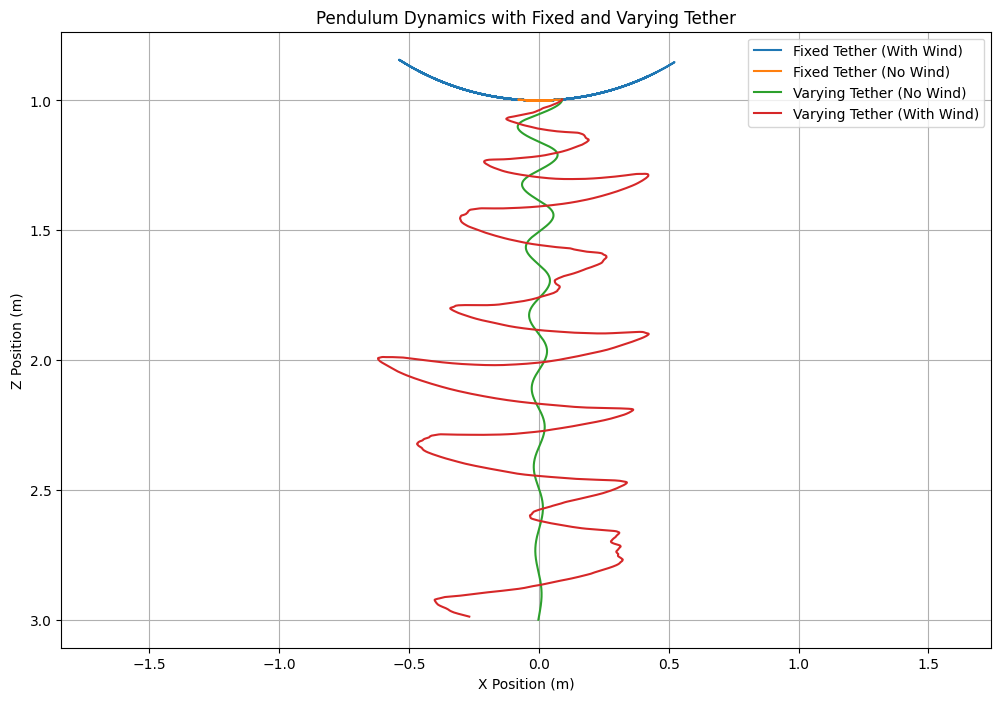

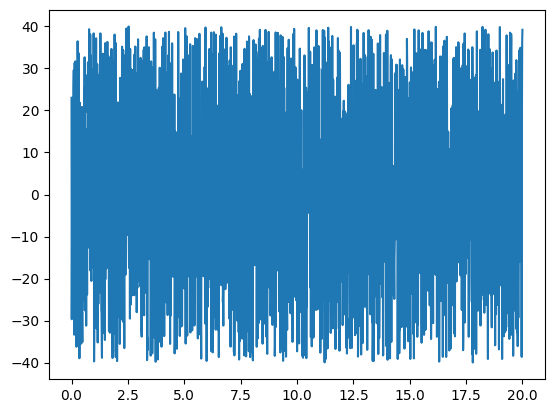

In [4]:
def dynamics_fixed(x, u, d):
    theta, theta_dot = x
    thrust = u[0]
    v_wind = d[0]
    theta_ddot = (thrust/(m*l0) - g/l0*jnp.sin(theta) + 
                 C_d/(m*l0)*(v_wind - l0*theta_dot))
    return jnp.array([theta_dot, theta_ddot])

def dynamics_varying(x, u, d):
    theta, theta_dot, ell = x
    thrust, ell_dot = u[0], u[1]
    v_wind = d[0]
    theta_ddot = (thrust/(m*ell) - (g/ell)*jnp.sin(theta) - 2*(ell_dot/ell)*theta_dot + 
                (C_d/(m*ell))*(v_wind - (ell_dot*jnp.sin(theta) + ell*jnp.cos(theta)*theta_dot))*jnp.cos(theta))
    return jnp.array([theta_dot, theta_ddot, ell_dot])

# Now JIT compile them
dynamics_fixed_jit = jit(dynamics_fixed)
dynamics_varying_jit = jit(dynamics_varying)

# JIT-compiled RK4 step with static_argnums for the dynamics function
@partial(jit, static_argnums=(0,))
def rk4_step(f, x, u, d, dt):
    k1 = f(x, u, d)
    k2 = f(x + 0.5 * dt * k1, u, d)
    k3 = f(x + 0.5 * dt * k2, u, d)
    k4 = f(x + dt * k3, u, d)
    return x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

def simulate_system(dynamics, x0, u, wind_samples, dt, T_sim):
    N = int(T_sim / dt)
    xs = jnp.zeros((N, len(x0)))
    xs = xs.at[0].set(x0)
    
    def step(carry, i):
        x_prev = carry
        d = jnp.array([wind_samples[i]])
        x_next = rk4_step(dynamics, x_prev, u, d, dt)
        return x_next, x_next
    
    _, xs = jax.lax.scan(step, x0, jnp.arange(1, N))
    xs = jnp.concatenate([x0[jnp.newaxis, :], xs], axis=0)
    return xs

# Generate all wind samples upfront with fixed seed
wind_samples = random.uniform(key, (N,), minval=-v_wind_abs_max, maxval=v_wind_abs_max)

# Initial conditions
x0_fixed = jnp.array([theta0, theta_dot0])  # [theta, theta_dot]
x0_varying = jnp.array([theta0, theta_dot0, l0])  # [theta, theta_dot, ell]

# Control inputs
u_fixed = jnp.array([0.0])
u_varying = jnp.array([0.0, l_dot])

# Run simulations separately (can't JIT compile the whole thing due to different dynamics)
xs_fixed_no_wind = simulate_system(dynamics_fixed_jit, x0_fixed, u_fixed, jnp.zeros(N), dt, T_sim)
xs_varying_no_wind = simulate_system(dynamics_varying_jit, x0_varying, u_varying, jnp.zeros(N), dt, T_sim)
xs_fixed_wind = simulate_system(dynamics_fixed_jit, x0_fixed, u_fixed, wind_samples, dt, T_sim)
xs_varying_wind = simulate_system(dynamics_varying_jit, x0_varying, u_varying, wind_samples, dt, T_sim)

# Convert to numpy for plotting
xs_fixed_no_wind = np.array(xs_fixed_no_wind)
xs_varying_no_wind = np.array(xs_varying_no_wind)
xs_fixed_wind = np.array(xs_fixed_wind)
xs_varying_wind = np.array(xs_varying_wind)

# Rest of your plotting code...

# Plotting (same as before)
def get_xz_trace(theta_array, ell_array):
    x = ell_array * np.sin(theta_array)
    z = ell_array * np.cos(theta_array)
    return x, z

# ... rest of your plotting code ...

theta_fixed_no_wind = xs_fixed_no_wind[:, 0]
ell_fixed_no_wind = l0 * np.ones_like(theta_fixed_no_wind)
x_fixed_no_wind, z_fixed_no_wind = get_xz_trace(theta_fixed_no_wind, ell_fixed_no_wind)

theta_varying_no_wind = xs_varying_no_wind[:, 0]
ell_varying_no_wind = xs_varying_no_wind[:, 2]
x_varying_no_wind, z_varying_no_wind = get_xz_trace(theta_varying_no_wind, ell_varying_no_wind)

theta_fixed_with_wind = xs_fixed_wind[:, 0]
ell_fixed_with_wind = l0 * np.ones_like(theta_fixed_with_wind)
x_fixed_with_wind, z_fixed_with_wind = get_xz_trace(theta_fixed_with_wind, ell_fixed_with_wind)

theta_varying_with_wind = xs_varying_wind[:, 0]
ell_varying_with_wind = xs_varying_wind[:, 2]
x_varying_with_wind, z_varying_with_wind = get_xz_trace(theta_varying_with_wind, ell_varying_with_wind)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(x_fixed_with_wind, z_fixed_with_wind, label='Fixed Tether (With Wind)')
plt.plot(x_fixed_no_wind, z_fixed_no_wind, label='Fixed Tether (No Wind)')
plt.plot(x_varying_no_wind, z_varying_no_wind, label='Varying Tether (No Wind)')
plt.plot(x_varying_with_wind, z_varying_with_wind, label='Varying Tether (With Wind)')
plt.title('Pendulum Dynamics with Fixed and Varying Tether')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.xlabel('X Position (m)')
plt.ylabel('Z Position (m)')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(np.linspace(0,T_sim, N),wind_samples, label='Wind Speed Samples')

# Nominal PID controller

In [5]:
def PID_controller_fixed(dynamics, x0, u, dt, T_final, Kp, Ki, Kd, key):
    N = int(T_final / dt)

    @partial(jit, static_argnames=['dynamics', 'N'])
    def _pid_inner(dynamics, x0, u, dt, Kp, Ki, Kd, key, N):
        wind_samples = random.uniform(key, (N,), minval=-v_wind_abs_max, maxval=v_wind_abs_max)

        def pid_step(carry, i):
            x, integral, prev_error = carry
            v_wind = wind_samples[i]
            d = jnp.array([v_wind])

            theta = x[0]
            error = -theta
            integral = jnp.clip(integral + error * dt, -1.0, 1.0)
            derivative = (error - prev_error) / dt
            thrust = Kp * error + Ki * integral + Kd * derivative
            thrust = jnp.clip(thrust, -T_max_abs, T_max_abs)

            u_control = jnp.array([thrust])  # shape (1,)
            x_next = rk4_step(dynamics, x, u_control, d, dt)

            return (x_next, integral, error), (x_next, u_control, error)

        init_state = (x0, 0.0, 0.0)
        (_, _, _), (state_history, control_history, error_history) = lax.scan(
            pid_step, init_state, jnp.arange(N)
        )

        state_history = jnp.concatenate([x0[jnp.newaxis], state_history], axis=0)
        control_history = jnp.concatenate([u.reshape(1, 1), control_history], axis=0)  # shape-safe
        error_history = jnp.concatenate([jnp.array([-x0[0]]), error_history], axis=0)

        return state_history, control_history, error_history, wind_samples

    return _pid_inner(dynamics, x0, u, dt, Kp, Ki, Kd, key, N)


def PID_controller_varying(dynamics, x0, u, dt, T_final, Kp, Ki, Kd, key):
    N = int(T_final / dt)

    @partial(jit, static_argnames=['dynamics', 'N'])
    def _pid_inner(dynamics, x0, u, dt, Kp, Ki, Kd, key, N):
        wind_samples = random.uniform(key, (N,), minval=-v_wind_abs_max, maxval=v_wind_abs_max)

        def pid_step(carry, i):
            x, integral, prev_error = carry
            v_wind = wind_samples[i]
            d = jnp.array([v_wind])

            theta, theta_dot, ell = x
            error_theta = -theta
            integral_theta = jnp.clip(integral + error_theta * dt, -1.0, 1.0)
            derivative_theta = (error_theta - prev_error) / dt
            thrust = Kp * error_theta + Ki * integral_theta + Kd * derivative_theta
            thrust = jnp.clip(thrust, -T_max_abs, T_max_abs)

            ell_desired = ell_max
            ell_error = ell_desired - ell
            ell_dot = jnp.clip(Kp_ell * ell_error, ell_dot_min, ell_dot_max)

            u_control = jnp.array([thrust, ell_dot])  # shape (2,)
            x_next = rk4_step(dynamics, x, u_control, d, dt)

            return (x_next, integral_theta, error_theta), (x_next, u_control, error_theta)

        init_state = (x0, 0.0, 0.0)
        (_, _, _), (state_history, control_history, error_history) = lax.scan(
            pid_step, init_state, jnp.arange(N)
        )

        state_history = jnp.concatenate([x0[jnp.newaxis], state_history], axis=0)
        control_history = jnp.concatenate([u.reshape(1, 2), control_history], axis=0)  # shape-safe
        error_history = jnp.concatenate([jnp.array([-x0[0]]), error_history], axis=0)

        return state_history, control_history, error_history, wind_samples

    return _pid_inner(dynamics, x0, u, dt, Kp, Ki, Kd, key, N)



# JIT-compiled RK4 step
@partial(jit, static_argnums=(0,))
def rk4_step(f, x, u, d, dt):
    k1 = f(x, u, d)
    k2 = f(x + 0.5 * dt * k1, u, d)
    k3 = f(x + 0.5 * dt * k2, u, d)
    k4 = f(x + dt * k3, u, d)
    return x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)


# JIT dynamics
dynamics_fixed_jit = jit(dynamics_fixed)
dynamics_varying_jit = jit(dynamics_varying)

# Run PID simulations
pid_fixed_states, pid_fixed_controls, pid_fixed_error_history, pid_wind = PID_controller_fixed(
    dynamics_fixed_jit,
    jnp.array([theta0, theta_dot0]),
    jnp.array([0.0]),
    dt=dt,
    T_final=T_sim,
    Kp=Kp,
    Ki=Ki,
    Kd=Kd,
    key=key
)

pid_varying_states, pid_varying_controls, pid_varying_error_history, _ = PID_controller_varying(
    dynamics_varying_jit,
    jnp.array([theta0, theta_dot0, l0]),
    jnp.array([0.0, l_dot]),
    dt=dt,
    T_final=T_sim,
    Kp=Kp,
    Ki=Ki,
    Kd=Kd,
    key=key
)


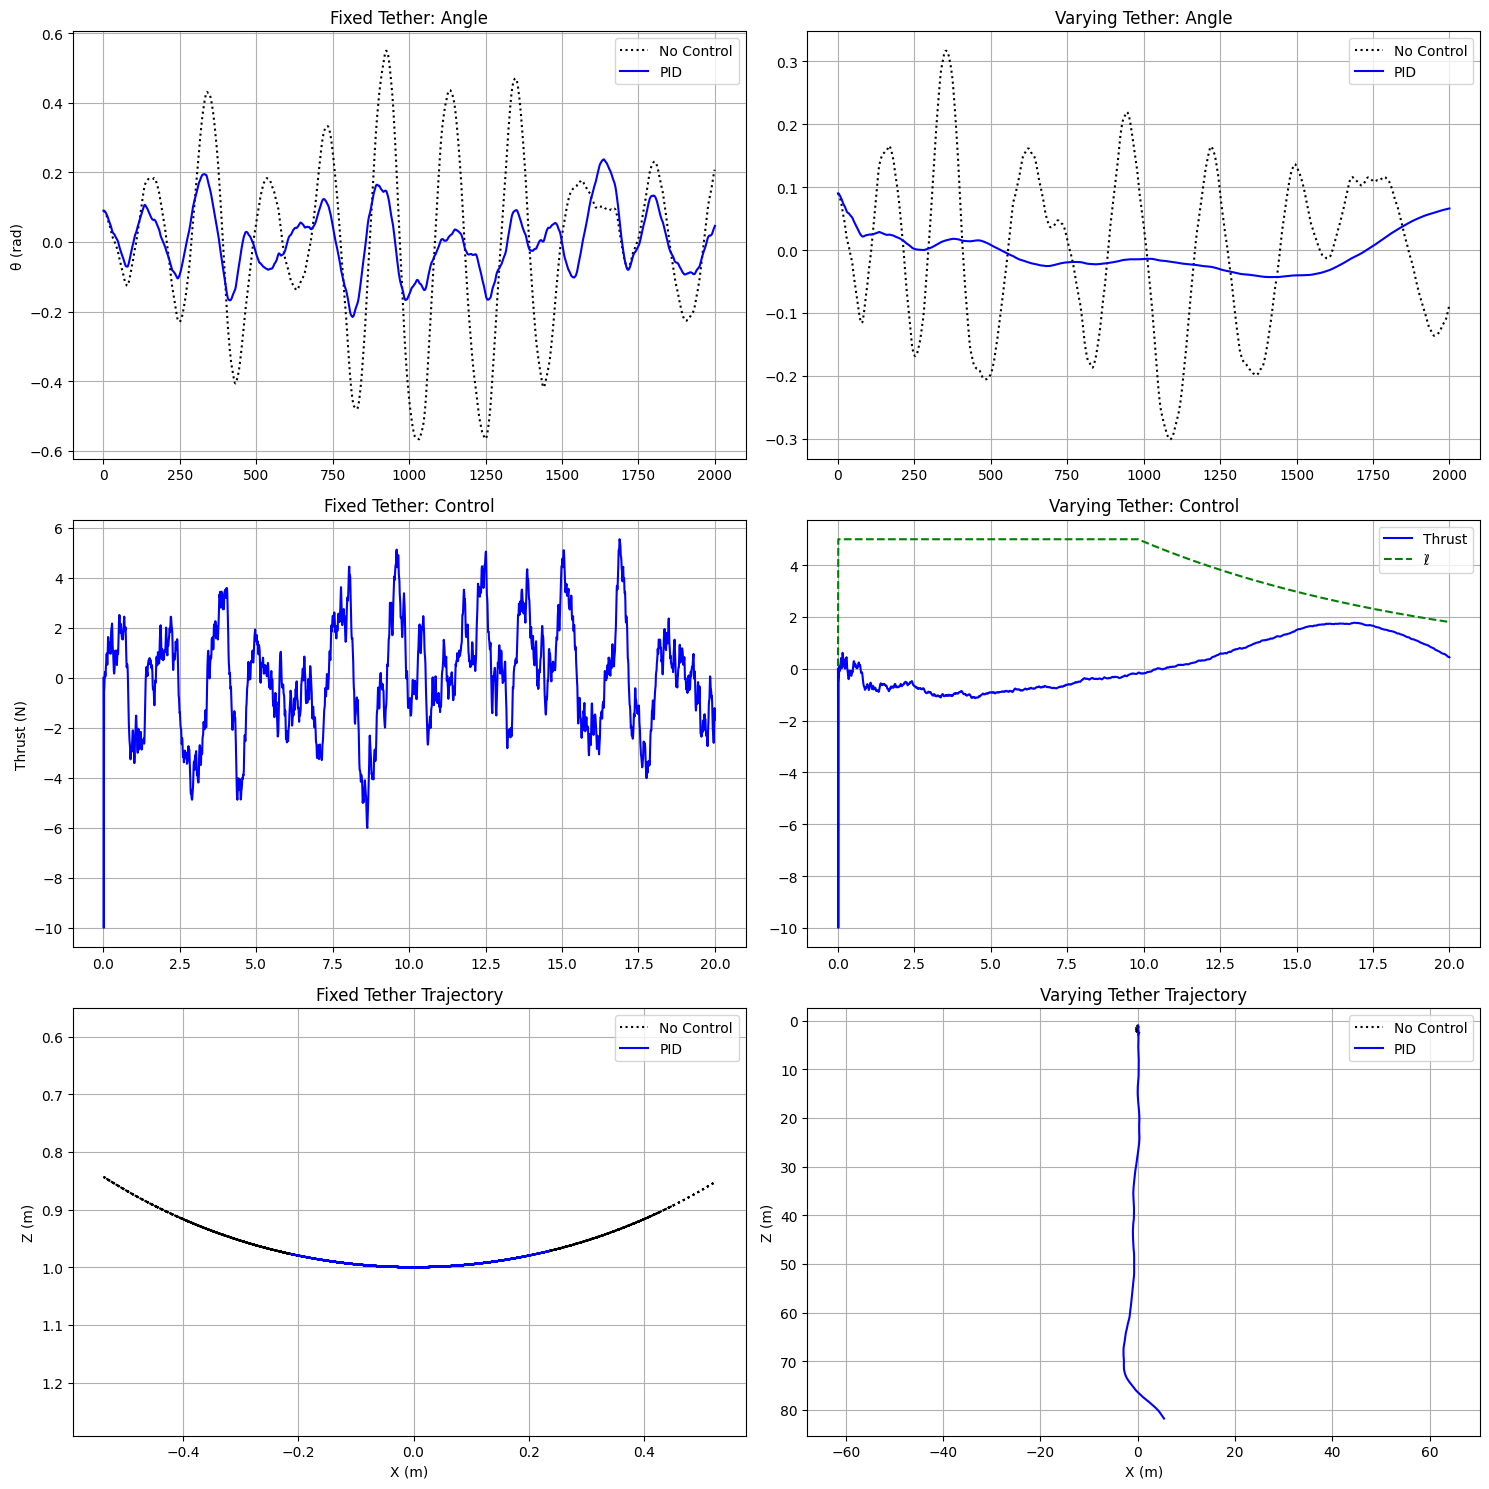

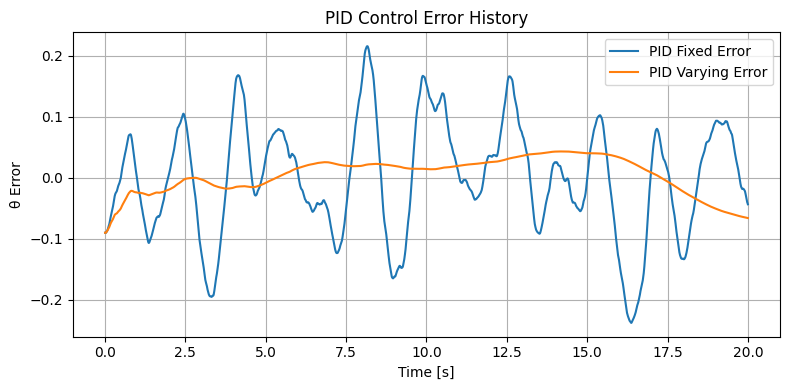

In [6]:
N = int(T_sim / dt)  # Ensure N is defined

# Comparative Plotting
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# --- Angle responses ---
axs[0, 0].plot(xs_fixed_wind[:, 0], 'k:', label='No Control')
axs[0, 0].plot(pid_fixed_states[:, 0], 'b-', label='PID')
axs[0, 0].set_title('Fixed Tether: Angle')
axs[0, 0].set_ylabel('θ (rad)')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(xs_varying_wind[:, 0], 'k:', label='No Control')
axs[0, 1].plot(pid_varying_states[:, 0], 'b-', label='PID')
axs[0, 1].set_title('Varying Tether: Angle')
axs[0, 1].legend()
axs[0, 1].grid(True)

# --- Control inputs ---
axs[1, 0].plot(np.linspace(0, T_sim, pid_fixed_controls.shape[0]), pid_fixed_controls, 'b-')
axs[1, 0].set_title('Fixed Tether: Control')
axs[1, 0].set_ylabel('Thrust (N)')
axs[1, 0].grid(True)

axs[1, 1].plot(np.linspace(0, T_sim, pid_varying_controls.shape[0]), pid_varying_controls[:, 0], 'b-', label='Thrust')
axs[1, 1].plot(np.linspace(0, T_sim, pid_varying_controls.shape[0]), pid_varying_controls[:, 1], 'g--', label='ℓ̇')
axs[1, 1].set_title('Varying Tether: Control')
axs[1, 1].legend()
axs[1, 1].grid(True)

# --- Trajectories ---
def plot_traj(ax, theta, ell, color, label):
    x, z = ell * np.sin(theta), ell * np.cos(theta)
    ax.plot(x, z, color, label=label)
    ax.axis('equal')
    ax.invert_yaxis()
    ax.grid(True)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)')

plot_traj(axs[2, 0], xs_fixed_wind[:, 0], l0, 'k:', 'No Control')
plot_traj(axs[2, 0], pid_fixed_states[:, 0], l0, 'b-', 'PID')
axs[2, 0].set_title('Fixed Tether Trajectory')
axs[2, 0].invert_yaxis()
axs[2, 0].legend()

plot_traj(axs[2, 1], xs_varying_wind[:, 0], xs_varying_wind[:, 2], 'k:', 'No Control')
plot_traj(axs[2, 1], pid_varying_states[:, 0], pid_varying_states[:, 2], 'b-', 'PID')
axs[2, 1].set_title('Varying Tether Trajectory')
# invert y axis
axs[2, 1].invert_yaxis()
axs[2, 1].legend()

plt.tight_layout()
plt.show()

# --- PID Error History Plot ---
plt.figure(figsize=(8, 4))
t_error = np.linspace(0, T_sim, N + 1)
plt.plot(t_error, pid_fixed_error_history, label='PID Fixed Error')
plt.plot(t_error, pid_varying_error_history, label='PID Varying Error')
plt.title('PID Control Error History')
plt.xlabel('Time [s]')
plt.ylabel('θ Error')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# HJ BRT Fixed Tether

Defining our own dynamics compatible with hj_reachability toolbox

Our open-loop dynamics are (for no thrust, no wind):
\begin{align*}
\dot{x} &= f(x,0,0) = \begin{bmatrix}
\dot{\theta} \\
-\frac{g}{l}\sin{\theta}
-\frac{C_D}{m} \cos{\theta}\dot{\theta}
\end{bmatrix}
\end{align*}

The control Jacobian is:
\begin{align*}
B &= \frac{\partial f}{\partial u} = \begin{bmatrix}
0 \\
\frac{1}{ml}
\end{bmatrix}
\end{align*}

The disturbance Jacobian is:
\begin{align*}
E &= \frac{\partial f}{\partial d} = \begin{bmatrix}
0 \\
\frac{C_D}{ml}
\end{bmatrix}
\end{align*}

In [23]:
class FixedTetherPendulum(hj.ControlAndDisturbanceAffineDynamics):
    def __init__(self, m, l0, g, C_d, d_max, T_max,
                 control_mode="min", disturbance_mode="max"):
        control_space = hj.sets.Box(lo=jnp.array([-T_max]),
                                    hi=jnp.array([T_max]))
        disturbance_space = hj.sets.Box(lo=jnp.array([-d_max]),
                                        hi=jnp.array([d_max]))
        super().__init__(control_mode=control_mode,
                         disturbance_mode=disturbance_mode,
                         control_space=control_space,
                         disturbance_space=disturbance_space)
        self.m = m
        self.l0 = l0
        self.g = g
        self.C_d = C_d

    def open_loop_dynamics(self, state, time):
        theta, theta_dot = state
        return jnp.array([
            theta_dot,
            -self.g/self.l0 * jnp.sin(theta) - self.C_d * theta_dot / self.m
        ])

    def control_jacobian(self, state, time):
        return jnp.array([
            [0],
            [1 / (self.m * self.l0)]
        ])

    def disturbance_jacobian(self, state, time):
        return jnp.array([
            [0],
            [self.C_d / (self.m * self.l0)]
        ])
    
    def step(self, x, u, dt, d=None, time=0.0):
        """Integrate one time step using forward Euler (or pass to a better integrator)."""
        f = self.open_loop_dynamics(x, time)
        g = self.control_jacobian(x, time) @ jnp.atleast_1d(u)
        if d is not None:
            h = self.disturbance_jacobian(x, time) @ jnp.atleast_1d(d)
        else:
            h = 0.0
        x_dot = f + g + h
        return x + dt * x_dot


In [45]:
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    domain=hj.sets.Box(
        lo=jnp.array([-theta_bounds, -theta_dot_bounds]),
        hi=jnp.array([theta_bounds, theta_dot_bounds])
    ),
    shape=(200, 200),
    periodic_dims=None
)


In [46]:
# values = (grid.states[..., 0]**2 - theta_unsafe_radius**2)
values = (grid.states[..., 0]**2 + alpha * grid.states[..., 1]**2 - theta_unsafe_radius**2)


In [47]:
generate_new_HJ_fixed = True
# File to cache the computed HJ solution
HJ_CACHE_FILE = f"target_values_{T_sim}_sec.npy"

if os.path.exists(HJ_CACHE_FILE) and not generate_new_HJ_fixed:
    print(f"Loading cached target_values from {HJ_CACHE_FILE}")
    target_values = np.load(HJ_CACHE_FILE)
else:
    print(f"Computing target_values and saving to {HJ_CACHE_FILE}")

    solver_settings = hj.SolverSettings.with_accuracy(
        "low",
        hamiltonian_postprocessor=hj.solver.backwards_reachable_tube
    )

    dynamics = FixedTetherPendulum(
        m=m, l0=l0, g=g, C_d=C_d,
        d_max=v_wind_abs_max, T_max=T_max_abs
    )

    time = 0.
    target_time = -0.1  # simulate backwards in time

    target_values = hj.step(
        solver_settings, dynamics, grid, time, values, target_time
    )

    # Save for reuse
    np.save(HJ_CACHE_FILE, np.array(target_values))


Computing target_values and saving to target_values_20_sec.npy


100%|##########|  0.1000/0.10000000149011612 [00:00<00:00,  8.84s/sim_s]


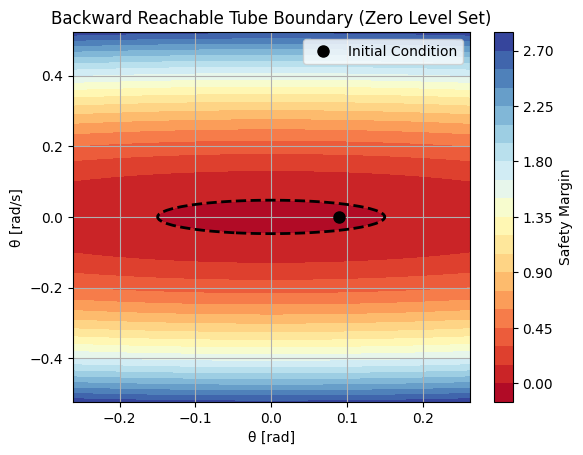

In [48]:
plt.contourf(
    grid.coordinate_vectors[0],
    grid.coordinate_vectors[1],
    target_values.T,
    levels=20,
    cmap='RdYlBu'
)
plt.colorbar(label='Safety Margin')

plt.contour(
    grid.coordinate_vectors[0],
    grid.coordinate_vectors[1],
    target_values.T,
    levels=[0],
    colors='black',
    linewidths=2,
    linestyles='dashed'
)
plt.plot(theta0, theta_dot0, 'ko', markersize=8, label="Initial Condition")  # 'ko' = black circle

plt.xlabel("θ [rad]")
plt.ylabel("θ̇ [rad/s]")
plt.title("Backward Reachable Tube Boundary (Zero Level Set)")
plt.grid(True)
plt.legend()
plt.show()


In [49]:
V_func = RegularGridInterpolator(
    points=(
        jnp.array(grid.coordinate_vectors[0]),
        jnp.array(grid.coordinate_vectors[1])
    ),
    values=jnp.array(target_values.T),  # shape must match (dim0, dim1)
    method="linear",
    fill_value=jnp.nan  # or 0.0 if you want a conservative safe fallback
)


In [50]:
def h_hj(x):
    x = jnp.array(x)
    V_val = V_func(x)
    return -V_val[0]  # extract scalar from 1-element array


In [51]:
x_test = jnp.array([theta0, theta_dot0])  # within grid bounds
print(h_hj(x_test))


-0.30155924


# CBF Safety Filter Controller Fixed Tether

In [116]:
# --- Smooth extended class-K function ---
def alpha_h(h_val, kind="smoothstep", kappa=1.0, epsilon=1e-4):
    if kind == "linear":
        return kappa * h_val
    elif kind == "log":
        return kappa * np.log(h_val + epsilon)
    elif kind == "reciprocal":
        return kappa / (h_val + epsilon)
    elif kind == "smoothstep":
        return kappa * h_val / np.sqrt(1 + h_val**2)
    else:
        raise ValueError("Unknown alpha function kind.")

def h_cbf(x):
    theta = x[0]
    theta_dot = x[1]
    return theta_max**2 - theta**2 - alpha * theta_dot**2


# --- Pendulum dynamics ---
@jit
def dynamics_fixed(x, u, d):
    theta, theta_dot = x
    thrust = u[0]
    v_wind = d[0]
    theta_ddot = (thrust / (m * l0)
                  - g / l0 * jnp.sin(theta)
                  + C_d / (m * l0) * (v_wind - l0 * theta_dot))
    return jnp.array([theta_dot, theta_ddot])

@jit
def drift_field(x):
    theta, theta_dot = x
    theta_ddot = -(g / l0) * jnp.sin(theta) - (C_d / m) * theta_dot
    return jnp.array([theta_dot, theta_ddot])

@jit
def control_field(x):
    return jnp.array([0.0, 1.0 / (m * l0)])

# --- CBF-QP controller with soft constraint (slack variable) ---
# --- CBF-QP controller with soft constraint, regularization, warm start, and tight bounds ---
last_qp_vars = {"u": None, "slack": None}  # Persistent across calls

def cbf_qp_controller(f, g, h, x, u_nom, u_min, u_max,
                      alpha_fn, alpha_kwargs={}, slack_penalty=1000.0, reg=1e-4,
                      debug=False):
    grad_h = grad(h)(x)
    Lf_h = float(jnp.dot(grad_h, f(x)))
    Lg_h = float(jnp.dot(grad_h, g(x)))
    h_val = float(h(x))
    # alpha_val = float(alpha_fn(h_val, **alpha_kwargs))

    # Tighten control bounds slightly
    margin = 0
    u_min_tight = u_min + margin
    u_max_tight = u_max - margin

    u = cp.Variable(1)
    slack = cp.Variable(1, nonneg=True)

    objective = cp.Minimize(
        cp.sum_squares(u - u_nom) +
        slack_penalty * cp.square(slack) +
        reg * cp.sum_squares(u)
    )

    constraint_expr = Lg_h * u + Lf_h + slack
    constraints = [
        constraint_expr >= 0,
        u >= u_min_tight,
        u <= u_max_tight
    ]

    prob = cp.Problem(objective, constraints)

    if last_qp_vars["u"] is not None:
        u.value = last_qp_vars["u"]
        slack.value = last_qp_vars["slack"]

    try:
        prob.solve(warm_start=True, verbose=False)
        
    except Exception as e:
        print("QP solve exception:", e)
        print("  STATE:")
        print("    theta:     {:.4f}".format(x[0]))
        print("    theta_dot: {:.4f}".format(x[1]))
        print("    u_nom:     {:.4f}".format(u_nom))
        print("  h(x):", h_val)
        print("  Lf_h:", Lf_h)
        print("  Lg_h:", Lg_h)
        # print("  alpha(h):", alpha_val)
        print("  constraint (Lgh*u + Lfh + alpha + slack >= 0):")
        # print("    = {:.4f}*u + {:.4f} + {:.4f} + slack".format(Lg_h, Lf_h, alpha_val))
        print("  u bounds: [{:.4f}, {:.4f}]".format(u_min_tight, u_max_tight))
        return float(np.clip(u_nom, u_min, u_max))

    if u.value is None:
        print("QP failed.")
        print("  STATE:")
        print("    theta:     {:.4f}".format(x[0]))
        print("    theta_dot: {:.4f}".format(x[1]))
        print("    u_nom:     {:.4f}".format(u_nom))
        print("  h(x):", h_val)
        print("  Lf_h:", Lf_h)
        print("  Lg_h:", Lg_h)
        # print("  alpha(h):", alpha_val)
        print("  constraint (Lgh*u + Lfh + alpha + slack >= 0):")
        # print("    = {:.4f}*u + {:.4f} + {:.4f} + slack".format(Lg_h, Lf_h, alpha_val))
        print("  u bounds: [{:.4f}, {:.4f}]".format(u_min_tight, u_max_tight))
        return float(np.clip(u_nom, u_min, u_max))

    if debug:
        print("QP succeeded:")
        print("  h(x):", h_val)
        print("  u*: {:.4f}".format(u.value[0]))
        print("  slack: {:.6f}".format(slack.value[0]))
        print("  constraint residual:", constraint_expr.value)
        print("  STATE:")
        print("    theta:     {:.4f}".format(x[0]))
        print("    theta_dot: {:.4f}".format(x[1]))
        print("    u_nom:     {:.4f}".format(u_nom))

    last_qp_vars["u"] = u.value
    last_qp_vars["slack"] = slack.value

    return float(u.value)

# --- RK4 integrator ---
def rk4_step(f, x, u, d, dt):
    k1 = f(x, u, d)
    k2 = f(x + 0.5 * dt * k1, u, d)
    k3 = f(x + 0.5 * dt * k2, u, d)
    k4 = f(x + dt * k3, u, d)
    return x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

# --- PID controller ---
def pid_controller(x, integral, prev_error, dt):
    error = -x[0]
    integral = jnp.clip(integral + error * dt, -1.0, 1.0)
    derivative = (error - prev_error) / dt
    u_pid = Kp * error + Ki * integral + Kd * derivative
    return jnp.clip(u_pid, -T_max_abs, T_max_abs), integral, error

# --- Simulation loop ---
def simulate(h):
    N = int(T_sim / dt)
    wind = np.random.uniform(-v_wind_abs_max, v_wind_abs_max, N)

    x = np.array([theta0, theta_dot0])
    integral = 0.0
    prev_error = 0.0

    states = []
    controls = []
    h_vals = []

    for t in range(N):
        w_t = wind[t]
        u_pid, integral, prev_error = pid_controller(x, integral, prev_error, dt)

        u_safe = cbf_qp_controller(
            f=drift_field,
            g=control_field,
            h=h,
            x=x,
            u_nom=float(u_pid),
            u_min=-T_max_abs,
            u_max=T_max_abs,
            alpha_fn=alpha_h,
            alpha_kwargs={"kind": "smoothstep", "kappa": 10},
            slack_penalty=1000.0,
            debug = True
        )

        d = np.array([w_t])
        x = rk4_step(dynamics_fixed, x, np.array([u_safe]), d, dt)
        h_val = h(x)

        states.append(x)
        controls.append(u_safe)
        h_vals.append(h_val)

    return {
        "states": np.stack(states),
        "controls": np.stack(controls),
        "h_vals": np.stack(h_vals),
        "wind": wind
    }


In [117]:
print("Running with handcrafted CBF...")
history_cbf = simulate(h_cbf)

Running with handcrafted CBF...
QP succeeded:
  h(x): 0.0144
  u*: -9.9990
  slack: 0.000000
  constraint residual: [0.]
  STATE:
    theta:     0.0900
    theta_dot: 0.0000
    u_nom:     -10.0000
QP succeeded:
  h(x): -0.020120318979024887
  u*: 3.3786
  slack: 0.012379
  constraint residual: [-6.59194921e-17]
  STATE:
    theta:     0.0897
    theta_dot: -0.0588
    u_nom:     -0.2606
QP succeeded:
  h(x): -0.004155764356255531
  u*: 3.3425
  slack: 0.015996
  constraint residual: [0.]
  STATE:
    theta:     0.0892
    theta_dot: -0.0432
    u_nom:     -0.1157


/var/folders/qs/76sxk8bx6y7d6061nqr8wgcm0000gq/T/ipykernel_20095/251200534.py:128: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/var/folders/qs/76sxk8bx6y7d6061nqr8wgcm0000gq/T/ipykernel_20095/251200534.py:128: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



QP succeeded:
  h(x): -0.0778261125087738
  u*: 3.3222
  slack: 0.006889
  constraint residual: [-1.12757026e-16]
  STATE:
    theta:     0.0885
    theta_dot: -0.0962
    u_nom:     0.0098
QP succeeded:
  h(x): -0.15348586440086365
  u*: 3.2523
  slack: 0.004537
  constraint residual: [-2.1944252e-16]
  STATE:
    theta:     0.0874
    theta_dot: -0.1298
    u_nom:     0.3095
QP succeeded:
  h(x): -0.47310373187065125
  u*: 3.0983
  slack: 0.002129
  constraint residual: [-3.95950633e-16]
  STATE:
    theta:     0.0856
    theta_dot: -0.2210
    u_nom:     0.7466
QP succeeded:
  h(x): -0.4116901159286499
  u*: 3.0298
  slack: 0.001947
  constraint residual: [-7.94069671e-16]
  STATE:
    theta:     0.0835
    theta_dot: -0.2067
    u_nom:     1.0182
QP succeeded:
  h(x): -0.5105328559875488
  u*: 2.9231
  slack: 0.001632
  constraint residual: [-2.53703308e-16]
  STATE:
    theta:     0.0813
    theta_dot: -0.2294
    u_nom:     1.0506
QP succeeded:
  h(x): -1.023698091506958
  u*: 2.

In [118]:
print("\nRunning with HJ-derived CBF...")
history_hj = simulate(h_hj)


Running with HJ-derived CBF...
QP succeeded:
  h(x): -0.3015592396259308
  u*: -9.9990
  slack: 0.000000
  constraint residual: [0.]
  STATE:
    theta:     0.0900
    theta_dot: 0.0000
    u_nom:     -10.0000


/var/folders/qs/76sxk8bx6y7d6061nqr8wgcm0000gq/T/ipykernel_20095/251200534.py:128: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



QP succeeded:
  h(x): -0.3024790287017822
  u*: -0.9341
  slack: 0.147397
  constraint residual: [-5.55111512e-17]
  STATE:
    theta:     0.0901
    theta_dot: 0.0222
    u_nom:     -0.5465
QP succeeded:
  h(x): -0.3042101562023163
  u*: -1.1855
  slack: 0.164443
  constraint residual: [-2.77555756e-17]
  STATE:
    theta:     0.0903
    theta_dot: 0.0252
    u_nom:     -0.6447
QP succeeded:
  h(x): -0.3049319386482239
  u*: -0.5744
  slack: 0.000000
  constraint residual: [0.00405669]
  STATE:
    theta:     0.0905
    theta_dot: -0.0006
    u_nom:     -0.5745
QP succeeded:
  h(x): -0.3037915825843811
  u*: -0.3327
  slack: 0.000000
  constraint residual: [0.30762207]
  STATE:
    theta:     0.0902
    theta_dot: -0.0461
    u_nom:     -0.3327
QP succeeded:
  h(x): -0.30034446716308594
  u*: -0.0605
  slack: 0.000000
  constraint residual: [0.53817734]
  STATE:
    theta:     0.0896
    theta_dot: -0.0800
    u_nom:     -0.0605
QP succeeded:
  h(x): -0.29561468958854675
  u*: 0.2482


In [119]:
CBF_pid_fixed_states = history_cbf['states']
CBF_pid_fixed_controls = history_cbf['controls']
CBF_hj_pid_fixed_states = history_hj['states']
CBF_hj_pid_fixed_controls = history_hj['controls']

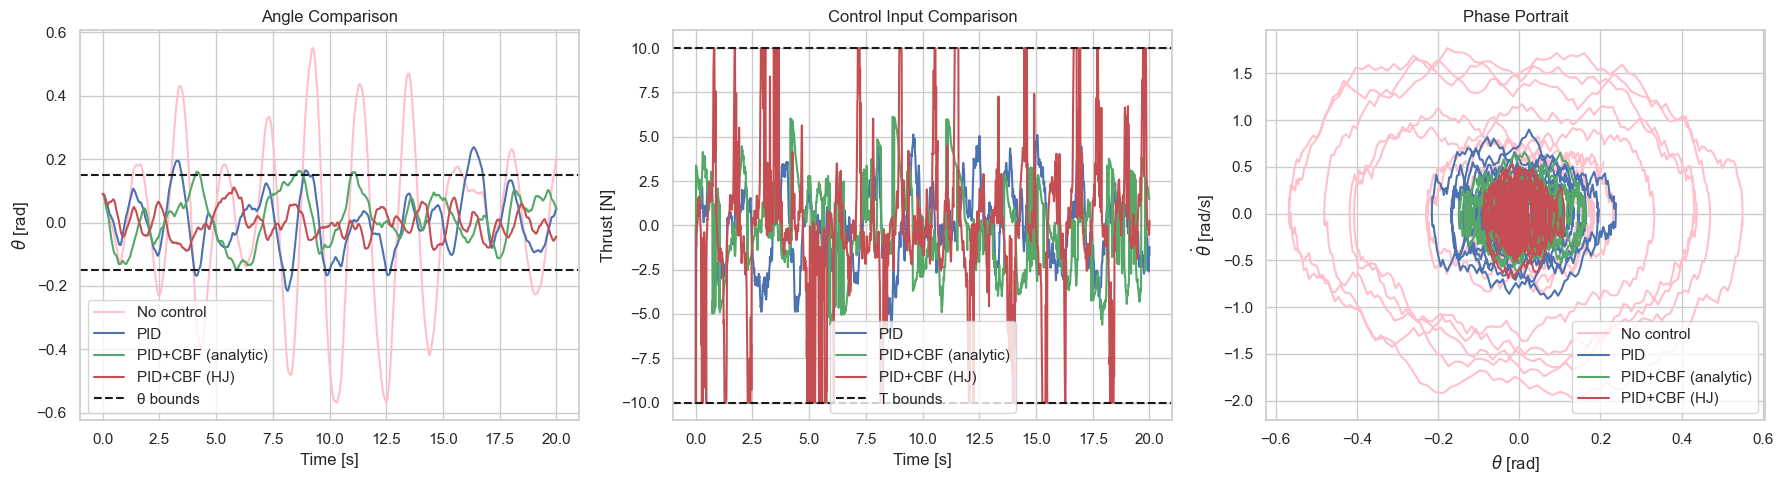

In [120]:
# Time arrays
t_noctrl = jnp.linspace(0, T_sim, xs_fixed_wind.shape[0])                  # N+1
t_pid = jnp.linspace(0, T_sim, pid_fixed_states.shape[0])                  # N+1
t_cbf = jnp.linspace(0, T_sim, CBF_pid_fixed_states.shape[0])              # N+1
t_hjcbf = jnp.linspace(0, T_sim, CBF_hj_pid_fixed_states.shape[0])         # N+1
t_controls = jnp.linspace(0, T_sim, pid_fixed_controls.shape[0])           # N
t_controls_hj = jnp.linspace(0, T_sim, CBF_hj_pid_fixed_controls.shape[0]) # N

plt.figure(figsize=(18, 5))

# --- 1. Angle comparison ---
plt.subplot(1, 3, 1)
plt.plot(t_noctrl, xs_fixed_wind[:, 0], color='pink', label='No control')
plt.plot(t_pid, pid_fixed_states[:, 0], 'b-', label='PID')
plt.plot(t_cbf, CBF_pid_fixed_states[:, 0], 'g-', label='PID+CBF (analytic)')
plt.plot(t_hjcbf, CBF_hj_pid_fixed_states[:, 0], 'r-', label='PID+CBF (HJ)')
plt.axhline(y=theta_max, color='k', linestyle='--', label='θ bounds')
plt.axhline(y=-theta_max, color='k', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel(r'$\theta$ [rad]')
plt.title('Angle Comparison')
plt.legend()

# --- 2. Control input comparison ---
plt.subplot(1, 3, 2)
plt.plot(t_controls, pid_fixed_controls, 'b-', label='PID')
plt.plot(t_controls[:-1], CBF_pid_fixed_controls, 'g-', label='PID+CBF (analytic)')
plt.plot(t_controls_hj, CBF_hj_pid_fixed_controls, 'r-', label='PID+CBF (HJ)')
plt.axhline(y=T_max_abs, color='k', linestyle='--', label='T bounds')
plt.axhline(y=-T_max_abs, color='k', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Thrust [N]')
plt.title('Control Input Comparison')
plt.legend()

# --- 3. Phase portrait (θ vs θ̇) ---
plt.subplot(1, 3, 3)
plt.plot(xs_fixed_wind[:, 0], xs_fixed_wind[:, 1], color='pink', label='No control')
plt.plot(pid_fixed_states[:, 0], pid_fixed_states[:, 1], 'b-', label='PID')
plt.plot(CBF_pid_fixed_states[:, 0], CBF_pid_fixed_states[:, 1], 'g-', label='PID+CBF (analytic)')
plt.plot(CBF_hj_pid_fixed_states[:, 0], CBF_hj_pid_fixed_states[:, 1], 'r-', label='PID+CBF (HJ)')
plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\dot{\theta}$ [rad/s]')
plt.title('Phase Portrait')
plt.legend()

plt.tight_layout()
plt.show()


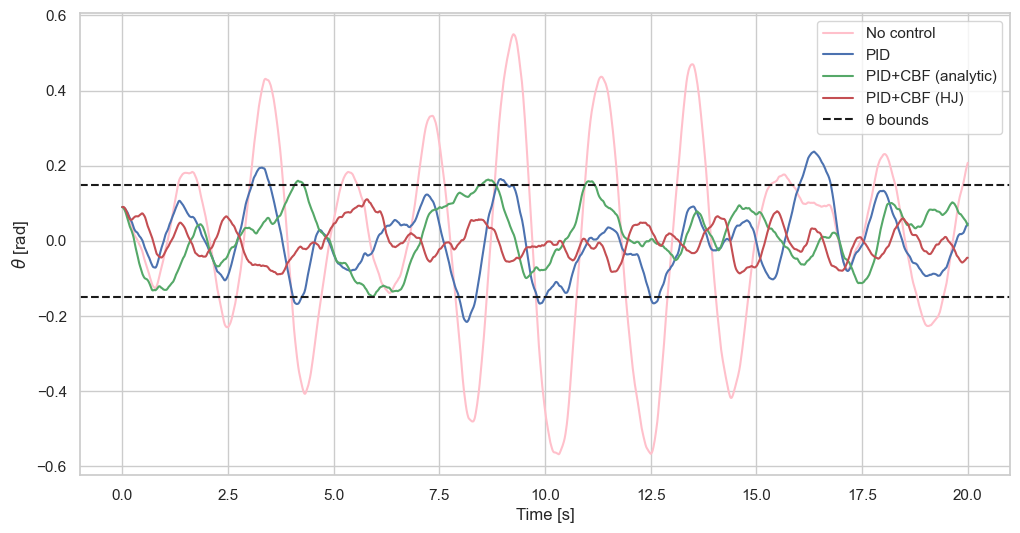

In [121]:
plt.figure(figsize=(12, 6))
plt.plot(t_noctrl, xs_fixed_wind[:, 0], color='pink', label='No control')
plt.plot(t_pid, pid_fixed_states[:, 0], 'b-', label='PID')
plt.plot(t_cbf, CBF_pid_fixed_states[:, 0], 'g-', label='PID+CBF (analytic)')
plt.plot(t_hjcbf, CBF_hj_pid_fixed_states[:, 0], 'r-', label='PID+CBF (HJ)')
plt.axhline(y=theta_max, color='k', linestyle='--', label='θ bounds')
plt.axhline(y=-theta_max, color='k', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel(r'$\theta$ [rad]')
# plt.title('Angle Comparison')
plt.legend()

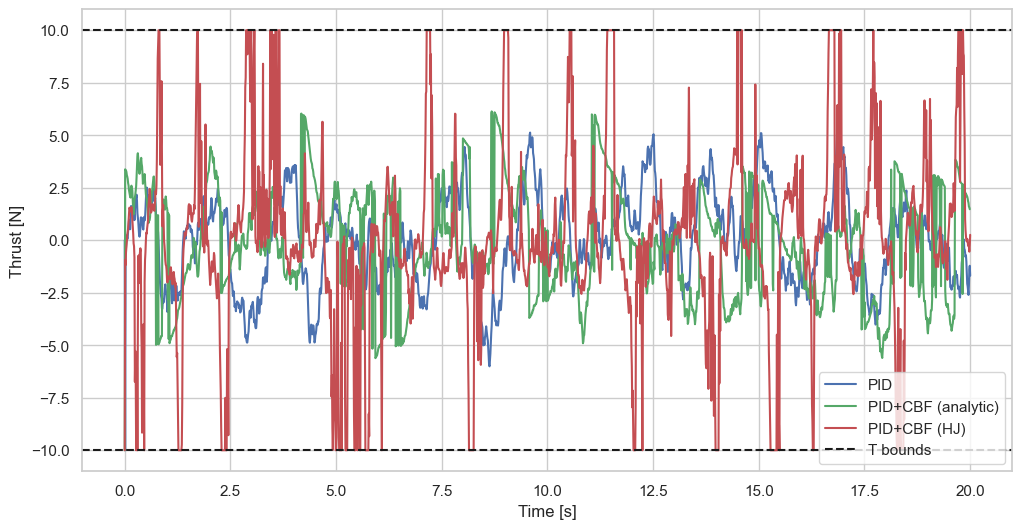

In [122]:
plt.figure(figsize=(12, 6))
plt.plot(t_controls, pid_fixed_controls, 'b-', label='PID')
plt.plot(t_controls[:-1], CBF_pid_fixed_controls, 'g-', label='PID+CBF (analytic)')
plt.plot(t_controls_hj, CBF_hj_pid_fixed_controls, 'r-', label='PID+CBF (HJ)')
plt.axhline(y=T_max_abs, color='k', linestyle='--', label='T bounds')
plt.axhline(y=-T_max_abs, color='k', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Thrust [N]')
# plt.title('Control Input Comparison')
plt.legend()

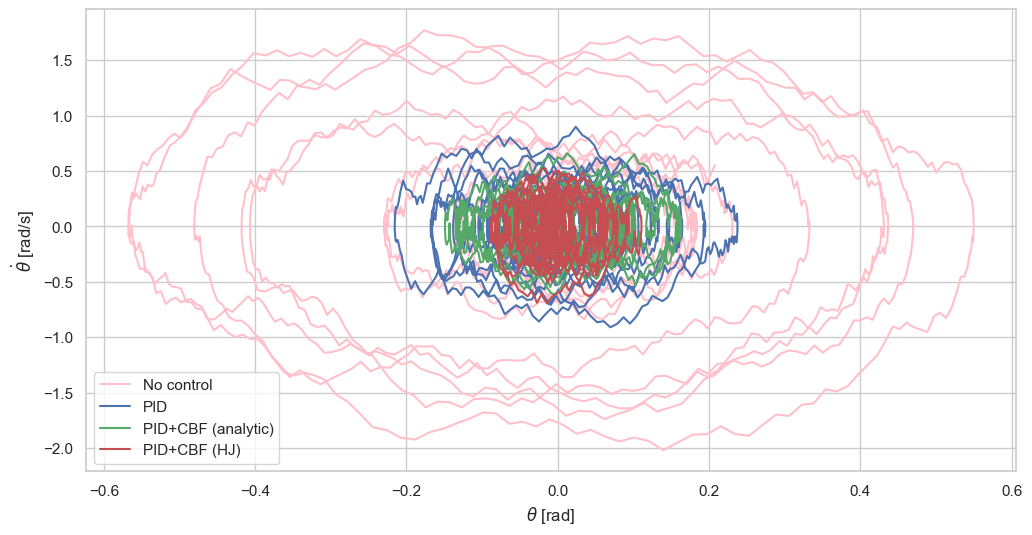

In [123]:
plt.figure(figsize=(12, 6))
plt.plot(xs_fixed_wind[:, 0], xs_fixed_wind[:, 1], color='pink', label='No control')
plt.plot(pid_fixed_states[:, 0], pid_fixed_states[:, 1], 'b-', label='PID')
plt.plot(CBF_pid_fixed_states[:, 0], CBF_pid_fixed_states[:, 1], 'g-', label='PID+CBF (analytic)')
plt.plot(CBF_hj_pid_fixed_states[:, 0], CBF_hj_pid_fixed_states[:, 1], 'r-', label='PID+CBF (HJ)')
plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\dot{\theta}$ [rad/s]')
# plt.title('Phase Portrait')
plt.legend()

# HJ BRT Varying Tether


We define the state as $ x = [\theta, \dot{\theta}, \ell]^\top $, the control as $ u = [T, \dot{\ell}]^\top $, and the disturbance as $ d = v_{\text{wind}} $.

The full nonlinear dynamics are:

$$
\dot{x} = f(x, u, d) =
\begin{bmatrix}
\dot{\theta} \\
\frac{T}{m\ell}
- \frac{g}{\ell} \sin{\theta}
- 2 \frac{\dot{\ell}}{\ell} \dot{\theta}
+ \frac{C_D}{m\ell} \left(
v_{\text{wind}} - \dot{\ell} \sin{\theta} - \ell \cos{\theta} \dot{\theta}
\right) \cos{\theta} \\
\dot{\ell}
\end{bmatrix}
$$

Open-Loop Dynamics (No Control, No Disturbance)

$$
f(x, 0, 0) =
\begin{bmatrix}
\dot{\theta} \\
- \frac{g}{\ell} \sin{\theta}
- 2 \frac{\dot{\ell}}{\ell} \dot{\theta}
+ \frac{C_D}{m\ell} \left(
- \dot{\ell} \sin{\theta} - \ell \cos{\theta} \dot{\theta}
\right) \cos{\theta} \\
\dot{\ell}
\end{bmatrix}
$$

Control Jacobian

$$
B(x) = \frac{\partial f}{\partial u} =
\begin{bmatrix}
0 & 0 \\
\frac{1}{m\ell} & 
\left(
-2 \frac{\dot{\theta}}{\ell} + 
\frac{C_D}{m\ell} \left( 
- \sin{\theta} \cos{\theta}
\right)
\right) \\
0 & 1
\end{bmatrix}
$$

Disturbance Jacobian

$$
E(x) = \frac{\partial f}{\partial d} =
\begin{bmatrix}
0 \\
\frac{C_D}{m\ell} \cos{\theta} \\
0
\end{bmatrix}
$$

In [58]:
class VaryingTetherPendulum(hj.ControlAndDisturbanceAffineDynamics):
    def __init__(self, m, g, C_d, d_max, T_max, l0, ell_dot_bounds,
                 control_mode="min", disturbance_mode="max"):
        # Save params
        self.m = m
        self.g = g
        self.C_d = C_d
        self.l0 = l0
        self.ell_dot_bounds = ell_dot_bounds

        # Controls: [T, ell_dot]
        T_lo, ell_dot_lo = -T_max, ell_dot_bounds[0]
        T_hi, ell_dot_hi = T_max, ell_dot_bounds[1]

        control_space = hj.sets.Box(
            lo=jnp.array([T_lo, ell_dot_lo]),
            hi=jnp.array([T_hi, ell_dot_hi])
        )

        disturbance_space = hj.sets.Box(
            lo=jnp.array([-d_max]),
            hi=jnp.array([d_max])
        )

        super().__init__(
            control_mode=control_mode,
            disturbance_mode=disturbance_mode,
            control_space=control_space,
            disturbance_space=disturbance_space
        )

    def open_loop_dynamics(self, state, time):
        theta, theta_dot, ell = state
        ell_dot = 0.0  # Passive evolution, no control applied here
        v_rel = -ell_dot * jnp.sin(theta) - ell * jnp.cos(theta) * theta_dot
        theta_ddot = (
            -self.g / ell * jnp.sin(theta)
            - 2 * (ell_dot / ell) * theta_dot
            + (self.C_d / (self.m * ell)) * v_rel * jnp.cos(theta)
        )
        return jnp.array([theta_dot, theta_ddot, ell_dot])

    def control_jacobian(self, state, time):
        theta, theta_dot, ell = state
        B_T = 1.0 / (self.m * ell)
        B_ell_dot = (
            -2.0 * theta_dot / ell
            - (self.C_d / (self.m * ell)) * jnp.sin(theta) * jnp.cos(theta)
        )
        return jnp.array([
            [0.0,     0.0],
            [B_T,     B_ell_dot],
            [0.0,     1.0]
        ])

    def disturbance_jacobian(self, state, time):
        theta, _, ell = state
        E = (self.C_d / (self.m * ell)) * jnp.cos(theta)
        return jnp.array([
            [0.0],
            [E],
            [0.0]
        ])

    def step(self, x, u, dt, d=None, time=0.0):
        """Forward Euler integration step with optional disturbance."""
        f = self.open_loop_dynamics(x, time)
        g = self.control_jacobian(x, time) @ jnp.atleast_1d(u)
        h = self.disturbance_jacobian(x, time) @ jnp.atleast_1d(d) if d is not None else 0.0
        return x + dt * (f + g + h)


In [59]:
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    domain=hj.sets.Box(
        lo=jnp.array([-theta_bounds, -theta_dot_bounds, ell_min]),
        hi=jnp.array([theta_bounds, theta_dot_bounds, ell_max])
    ),
    shape=(50, 50, 10),  # e.g., (50, 50, 30)
    periodic_dims=None
)


In [60]:
values = (jnp.abs(grid.states[..., 0]) - theta_unsafe_radius).reshape(grid.shape)

In [61]:
generate_new_HJ_varying = True

HJ_VARYING_CACHE_FILE = f"target_values_varying_{T_sim}_sec.npz"

if os.path.exists(HJ_VARYING_CACHE_FILE) and not generate_new_HJ_varying:
    print(f"Loading cached target_values from {HJ_VARYING_CACHE_FILE}")
    data = np.load(HJ_VARYING_CACHE_FILE)
    target_values = data['values']
    grid_shape = tuple(data['shape'])
    theta_vec = data['theta']
    theta_dot_vec = data['theta_dot']
    ell_vec = data['ell']
else:
    print(f"Computing target_values and saving to {HJ_VARYING_CACHE_FILE}")

    solver_settings = hj.SolverSettings.with_accuracy(
        "low",
        hamiltonian_postprocessor=hj.solver.backwards_reachable_tube
    )

    dynamics = VaryingTetherPendulum(
        m=m, l0=l0, g=g, C_d=C_d,
        d_max=v_wind_abs_max, T_max=T_max_abs,
        ell_dot_bounds=[ell_dot_min, ell_dot_max]
    )

    time = 0.
    target_time = -0.1  # simulate backwards in time

    target_values = hj.step(
        solver_settings, dynamics, grid, time, values, target_time
    )

    # Save to disk
    np.savez_compressed(HJ_VARYING_CACHE_FILE,
                        values=np.array(target_values),
                        shape=np.array(grid.shape),
                        theta=np.array(grid.coordinate_vectors[0]),
                        theta_dot=np.array(grid.coordinate_vectors[1]),
                        ell=np.array(grid.coordinate_vectors[2]))


Computing target_values and saving to target_values_varying_20_sec.npz


100%|##########|  0.1000/0.10000000149011612 [00:00<00:00,  4.34s/sim_s]


In [62]:
target_values.min(), target_values.max()

(Array(-0.14465716, dtype=float32), Array(0.11179939, dtype=float32))

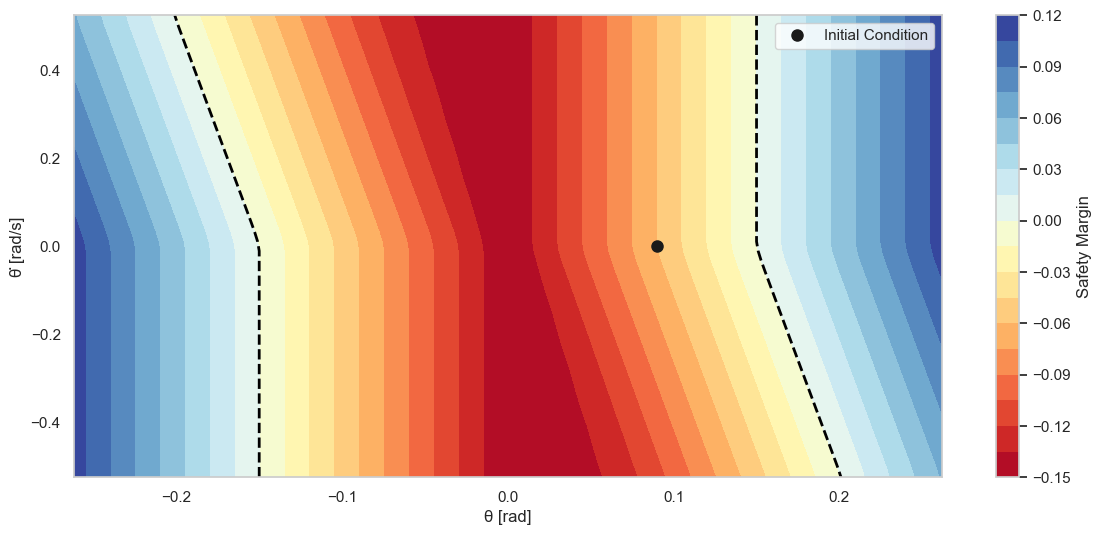

In [124]:
# Choose a slice index or ell value
ell_index = grid.shape[2] // 2  # middle of ell range
ell_val = grid.coordinate_vectors[2][ell_index]

# Extract 2D slice of value function at fixed ℓ
V_slice = target_values[:, :, ell_index]

# Plot
plt.figure(figsize=(14, 6))
plt.contourf(
    grid.coordinate_vectors[0],
    grid.coordinate_vectors[1],
    V_slice.T,  # transpose for correct orientation
    levels=20,
    cmap='RdYlBu'
)
plt.colorbar(label='Safety Margin')

# Plot zero level set (boundary of reachable set)
plt.contour(
    grid.coordinate_vectors[0],
    grid.coordinate_vectors[1],
    V_slice.T,
    levels=[0],
    colors='black',
    linewidths=2,
    linestyles='dashed'
)

# Initial condition (θ0, θ̇0)
plt.plot(theta0, theta_dot0, 'ko', markersize=8, label="Initial Condition")

# Labels
plt.xlabel("θ [rad]")
plt.ylabel("θ̇ [rad/s]")
# plt.title(f"CBF Reachable Set Slice at ℓ = {ell_val:.2f} m")
plt.grid(True)
plt.legend()
plt.show()


In [64]:
fig = go.Figure(data=go.Isosurface(
    x=grid.states[..., 0].ravel(),  # θ
    y=grid.states[..., 1].ravel(),  # θ̇
    z=grid.states[..., 2].ravel(),  # ℓ
    value=target_values.ravel(),   # Value function
    isomin=0,
    isomax=0,
    surface_count=1,
    colorscale="Jet",
    caps=dict(x_show=False, y_show=False, z_show=False),  # Hide cut faces
    showscale=True
))

fig.update_layout(
    title="3D Backward Reachable Tube (Zero Level Set)",
    scene=dict(
        xaxis_title="θ [rad]",
        yaxis_title="θ̇ [rad/s]",
        zaxis_title="ℓ [m]",
    ),
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()


In [65]:
V_func_varying = RegularGridInterpolator(
    points=(
        np.array(grid.coordinate_vectors[0]),  # θ
        np.array(grid.coordinate_vectors[1]),  # θ̇
        np.array(grid.coordinate_vectors[2])   # ℓ
    ),
    values=np.array(target_values),  # shape must match (dim0, dim1, dim2)
    method="linear",
    bounds_error=False,
    fill_value=np.nan  # or a conservative fallback like 1e6
)

In [66]:
def h_hj_varying(x):
    x = jnp.array(x)
    V_val = V_func_varying(x)
    return -V_val[0]  # extract scalar from 1-element array


In [67]:
x_test = jnp.array([theta0, theta_dot0, l0+1])  # within grid bounds
print(h_hj_varying(x_test))


0.0600618


# CBF Safety Filter Controller Varying Tether

In [ ]:
# Safety function
def h_cbf_varying(x):
    theta, theta_dot, ell = x

    h_angle = theta_max**2 - theta**2 - alpha * theta_dot**2
    h_ell_min = ell**2 - ell_min**2
    h_ell_max = ell_max**2 - ell**2

    return jnp.minimum(jnp.minimum(h_angle, h_ell_min), h_ell_max)

@jit
def dynamics_varying(x, u, d):
    theta, theta_dot, ell = x
    thrust, ell_dot = u
    v_wind = d[0]
    theta_ddot = (
        thrust / (m * ell)
        - (g / ell) * jnp.sin(theta)
        - 2 * (ell_dot / ell) * theta_dot
        + (C_d / (m * ell))
        * (v_wind - (ell_dot * jnp.sin(theta) + ell * jnp.cos(theta) * theta_dot))
        * jnp.cos(theta)
    )
    return jnp.array([theta_dot, theta_ddot, ell_dot])

@jit
def drift_field_varying(x):
    theta, theta_dot, ell = x
    theta_ddot = (
        - (g / ell) * jnp.sin(theta)
        + (C_d / (m * ell))
        * (- ell * jnp.cos(theta) * theta_dot)
        * jnp.cos(theta)
    )
    return jnp.array([theta_dot, theta_ddot, 0])

@jit
def control_field_varying(x):
    theta, theta_dot, ell = x

    # ∂f/∂u where u = [thrust, ell_dot]
    B_thrust = 1.0 / (m * ell)
    B_ell_dot = (
        -2.0 * theta_dot / ell
        - (C_d / (m * ell)) * jnp.sin(theta) * jnp.cos(theta)
    )

    return jnp.array([
        [0.0,       0.0],
        [B_thrust,  B_ell_dot],
        [0.0,       1.0]
    ])


# CBF filter using lax.fori_loop
# def cbf_safe_filter_varying(f, g, h, x, u_nom, kappa, epsilon):
#     grad_h = grad(h)(x)        # shape (3,)
#     Lf_h = jnp.dot(grad_h, f(x))
#     Lg_h = grad_h @ g(x)       # shape (2,)
#     h_val = h(x)

#     rhs = -kappa * h_val + (1.0 / epsilon) * (jnp.linalg.norm(Lg_h) ** 2)
#     rhs = 0

#     def proj_step(i, u):
#         constraint_val = Lf_h + jnp.dot(Lg_h, u) - rhs

#         def adjust(u):
#             step = 0.2 * (rhs - Lf_h - jnp.dot(Lg_h, u)) / (jnp.dot(Lg_h, Lg_h) + 1e-6)
#             return jnp.clip(u + step * Lg_h, jnp.array([-T_max_abs, ell_dot_min]), jnp.array([T_max_abs, ell_dot_max]))

#         return lax.cond(constraint_val < 0, adjust, lambda u: u, u)

#     return lax.fori_loop(0, 20, proj_step, u_nom)
def cbf_qp_filter_varying(f, g, h, x, u_nom, u_min, u_max,
                      alpha_fn, alpha_kwargs={}, slack_penalty=1000.0, reg=1e-4,
                      debug=False):
    grad_h = grad(h)(x)
    Lf_h = jnp.dot(grad_h, f(x)).item()
    Lg_h = np.array(grad_h @ g(x))  # shape (2,)
    h_val = h(x).item()

    u = cp.Variable(2)
    slack = cp.Variable(1, nonneg=True)

    objective = cp.Minimize(
        cp.sum_squares(u - u_nom) +
        slack_penalty * cp.square(slack) +
        reg * cp.sum_squares(u)
    )

    constraint_expr = Lg_h @ u + Lf_h + slack
    constraints = [
        constraint_expr >= 0,
        u[0] >= u_min[0],
        u[0] <= u_max[0],
        u[1] >= u_min[1],
        u[1] <= u_max[1]
    ]

    prob = cp.Problem(objective, constraints)

    try:
        prob.solve(warm_start=True, verbose=False)
    except Exception as e:
        if debug:
            print("QP exception:", e)
        return np.clip(u_nom, u_min, u_max)

    if u.value is None:
        if debug:
            print("QP failed.")
        return np.clip(u_nom, u_min, u_max)

    if debug:
        print("QP succeeded:")
        print("  h(x):", h_val)
        print("  u*: ", u.value)
        print("  slack:", slack.value)

    return np.array(u.value)

def pid_controller_varying(x, integral, prev_error, dt):
    error = -x[0]
    integral = jnp.clip(integral + error * dt, -1.0, 1.0)
    derivative = (error - prev_error) / dt

    thrust = Kp * error + Ki * integral + Kd * derivative
    thrust = jnp.clip(thrust, -T_max_abs, T_max_abs)

    ell = x[2] if len(x) > 2 else l0
    ell_err = ell_max - ell
    ell_dot = jnp.clip(0.1 * ell_err, ell_dot_min, ell_dot_max)

    return jnp.array([thrust.item(), ell_dot.item()]), integral, error



def simulate_varying_length(h):
    N = int(T_sim / dt)
    x = np.array([theta0, theta_dot0, l0])
    integral = np.array([0.0])
    prev_error = np.array([0.0])

    states = []
    controls = []

    for t in range(N):
        # PID controller
        u_pid, integral, prev_error = pid_controller_varying(x, integral, prev_error, dt)

        u_safe = cbf_qp_filter_varying(
            f=drift_field_varying,
            g=control_field_varying,
            h=h,
            x=x,
            u_nom=u_pid,
            u_min=np.array([-T_max_abs, ell_dot_min]),
            u_max=np.array([ T_max_abs, ell_dot_max]),
            alpha_fn=alpha_h,
            alpha_kwargs={"kind": "smoothstep", "kappa": 10},
            slack_penalty=1000.0,
            reg=1e-4,
            debug=False
        )

        # Simulate dynamics
        d = np.array([0.0])  # no wind
        x = rk4_step(dynamics_varying, x, u_safe, d, dt)

        states.append(x)
        controls.append(u_safe)

    return {
        "states": np.stack(states),
        "controls": np.stack(controls)
    }



In [140]:
# Run simulation
history = simulate_varying_length(h_cbf_varying)
CBF_pid_varying_states = history['states']
CBF_pid_varying_controls = history['controls']

In [141]:
# Run simulation
history = simulate_varying_length(h_hj_varying)
CBF_hj_pid_varying_states = history['states']
CBF_hj_pid_varying_controls = history['controls']

In [144]:
CBF_hj_pid_varying_controls.shape

(2000, 2)

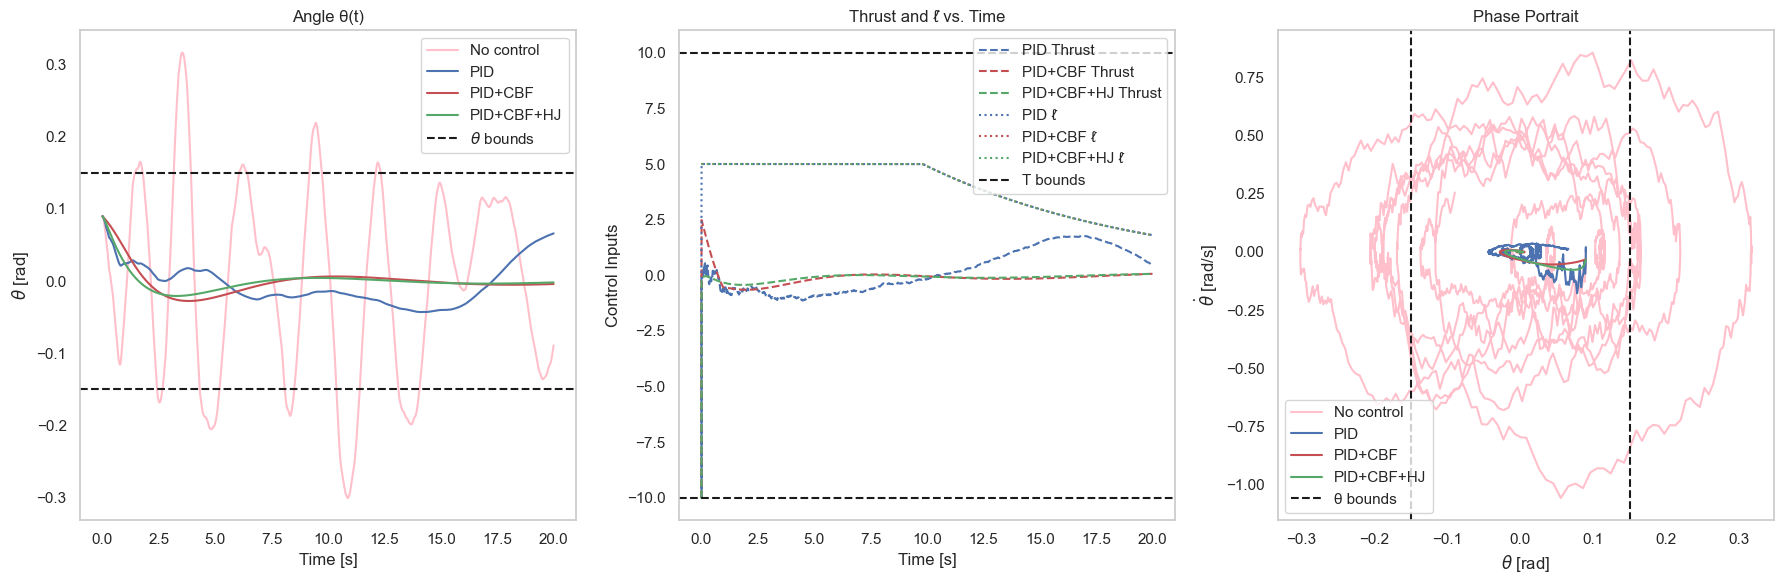

In [145]:
plt.figure(figsize=(18, 6))

# Time arrays
t_noctrl = jnp.linspace(0, T_sim, xs_varying_wind.shape[0])                      # N+1
t_pid = jnp.linspace(0, T_sim, pid_varying_states.shape[0])                      # N+1
t_cbf = jnp.linspace(0, T_sim, CBF_pid_varying_states.shape[0])                  # N+1
t_cbf_hj = jnp.linspace(0, T_sim, CBF_hj_pid_varying_states.shape[0])            # N+1

t_pid_u = jnp.linspace(0, T_sim, pid_varying_controls.shape[0])                  # N
t_cbf_u = jnp.linspace(0, T_sim, CBF_pid_varying_controls.shape[0])              # N
t_cbf_hj_u = jnp.linspace(0, T_sim, CBF_hj_pid_varying_controls.shape[0])        # N

# --- 1. Angle comparison ---
plt.subplot(1, 3, 1)
plt.plot(t_noctrl, xs_varying_wind[:, 0], color='pink', label='No control')
plt.plot(t_pid, pid_varying_states[:, 0], 'b-', label='PID')
plt.plot(t_cbf, CBF_pid_varying_states[:, 0], 'r-', label='PID+CBF')
plt.plot(t_cbf_hj, CBF_hj_pid_varying_states[:, 0], 'g-', label='PID+CBF+HJ')
plt.axhline(theta_max, color='k', linestyle='--', label=r'$\theta$ bounds')
plt.axhline(-theta_max, color='k', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel(r'$\theta$ [rad]')
plt.title('Angle θ(t)')
plt.legend()
plt.grid()

# --- 2. Control input comparison ---
plt.subplot(1, 3, 2)
# Thrust (u[0])
plt.plot(t_pid_u, pid_varying_controls[:, 0], 'b--', label='PID Thrust')
plt.plot(t_cbf_u, CBF_pid_varying_controls[:, 0], 'r--', label='PID+CBF Thrust')
plt.plot(t_cbf_hj_u, CBF_hj_pid_varying_controls[:, 0], 'g--', label='PID+CBF+HJ Thrust')

# ℓ̇ (u[1])
plt.plot(t_pid_u, pid_varying_controls[:, 1], 'b:', label='PID ℓ̇')
plt.plot(t_cbf_u, CBF_pid_varying_controls[:, 1], 'r:', label='PID+CBF ℓ̇')
plt.plot(t_cbf_hj_u, CBF_hj_pid_varying_controls[:, 1], 'g:', label='PID+CBF+HJ ℓ̇')

plt.axhline(T_max_abs, color='k', linestyle='--', label='T bounds')
plt.axhline(-T_max_abs, color='k', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Control Inputs')
plt.title('Thrust and ℓ̇ vs. Time')
plt.legend(loc='upper right')
plt.grid()

# --- 3. Phase portrait θ vs θ̇ ---
plt.subplot(1, 3, 3)
plt.plot(xs_varying_wind[:, 0], xs_varying_wind[:, 1], color='pink', label='No control')
plt.plot(pid_varying_states[:, 0], pid_varying_states[:, 1], 'b-', label='PID')
plt.plot(CBF_pid_varying_states[:, 0], CBF_pid_varying_states[:, 1], 'r-', label='PID+CBF')
plt.plot(CBF_hj_pid_varying_states[:, 0], CBF_hj_pid_varying_states[:, 1], 'g-', label='PID+CBF+HJ')
plt.axvline(x=-theta_max, color='k', linestyle='--', label='θ bounds')
plt.axvline(x=theta_max, color='k', linestyle='--')
plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\dot{\theta}$ [rad/s]')
plt.title('Phase Portrait')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


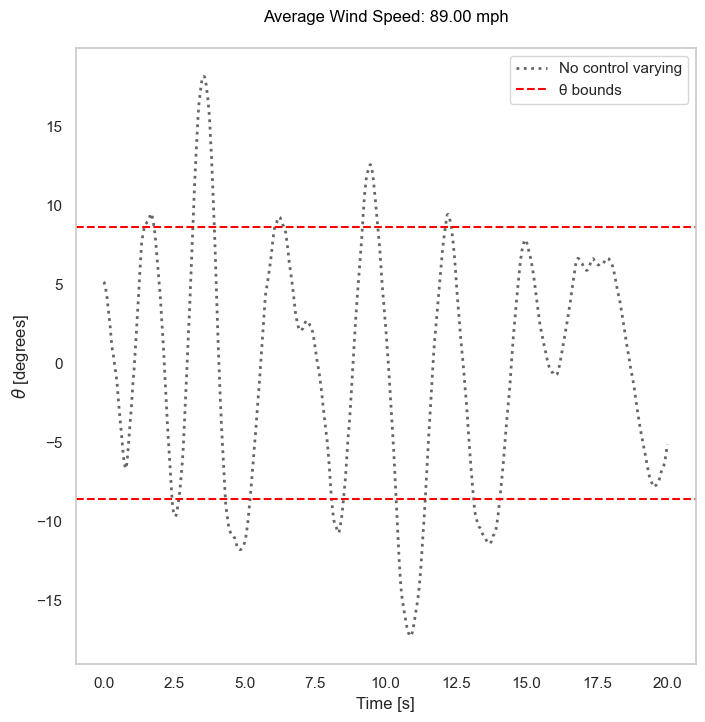

In [110]:
import seaborn as sns

# Convert radians to degrees
theta_varying_wind_deg = np.rad2deg(xs_varying_wind[:, 0])  # θ in degrees
theta_pid_varying_deg = np.rad2deg(pid_varying_states[:, 0])  # θ in degrees
theta_cbf_pid_varying_deg = np.rad2deg(CBF_pid_varying_states[:, 0])  # θ in degrees
theta_max_deg = np.rad2deg(theta_max)  # θ bounds in degrees

# Convert wind speed to mph (assuming wind_samples is in m/s)
wind_speed_mph = int(v_wind_abs_max * 2.23694)  # Conversion factor: 1 m/s = 2.23694 mph

# Set Seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(8, 8))
sns.lineplot(x=t_noctrl, y=theta_varying_wind_deg, label='No control varying', color="black", linestyle=':', alpha=0.6, linewidth=2)
# sns.lineplot(x=t_pid, y=theta_pid_varying_deg, label='PID', color="blue", linestyle='--', linewidth=2)
# sns.lineplot(x=t_pidcbf, y=theta_cbf_pid_varying_deg, label='PID+CBF', color="green", linewidth=2)

# Add horizontal lines for bounds
plt.axhline(y=theta_max_deg, color='red', linestyle='--', label='θ bounds')
plt.axhline(y=-theta_max_deg, color='red', linestyle='--')

# Add wind speed note
plt.text(0.5, 1.05, f"Average Wind Speed: {wind_speed_mph:.2f} mph", 
         horizontalalignment='center', verticalalignment='center', 
         transform=plt.gca().transAxes, fontsize=12, color='black')

# Customize labels and title
plt.xlabel('Time [s]')
plt.ylabel(r'$\theta$ [degrees]')
# plt.title('Angle Comparison (Varying Tether)')
plt.legend()
plt.grid()

# Show the plot
plt.show()

/var/folders/qs/76sxk8bx6y7d6061nqr8wgcm0000gq/T/ipykernel_20095/277905718.py:14: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.



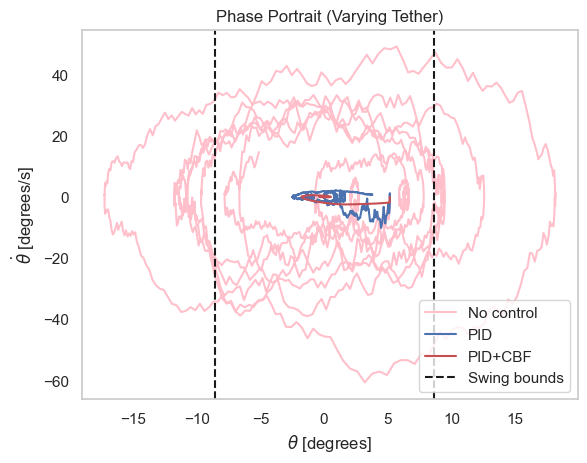

In [111]:
# Convert radians to degrees
theta_varying_wind_deg = np.rad2deg(xs_varying_wind[:, 0])  # θ in degrees
theta_dot_varying_wind_deg = np.rad2deg(xs_varying_wind[:, 1])  # θ̇ in degrees/s

theta_pid_varying_deg = np.rad2deg(pid_varying_states[:, 0])  # θ in degrees
theta_dot_pid_varying_deg = np.rad2deg(pid_varying_states[:, 1])  # θ̇ in degrees/s

theta_cbf_pid_varying_deg = np.rad2deg(CBF_pid_varying_states[:, 0])  # θ in degrees
theta_dot_cbf_pid_varying_deg = np.rad2deg(CBF_pid_varying_states[:, 1])  # θ̇ in degrees/s

theta_max_deg = np.rad2deg(theta_max)  # θ bounds in degrees

# Plotting
plt.plot(theta_varying_wind_deg, theta_dot_varying_wind_deg, 'k-', color="pink", label='No control')
plt.plot(theta_pid_varying_deg, theta_dot_pid_varying_deg, 'b-', label='PID')
plt.plot(theta_cbf_pid_varying_deg, theta_dot_cbf_pid_varying_deg, 'r-', label='PID+CBF')
plt.axvline(x=-theta_max_deg, color='k', linestyle='--', label='Swing bounds')
plt.axvline(x=theta_max_deg, color='k', linestyle='--')
plt.xlabel(r'$\theta$ [degrees]')
plt.ylabel(r'$\dot{\theta}$ [degrees/s]')
plt.title('Phase Portrait (Varying Tether)')
plt.legend()
plt.grid()
plt.show()